In [89]:

!pip install --upgrade transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


https://www.kaggle.com/code/omarjoual/arabic-bert

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import seaborn as sns
sns.set_theme(style="darkgrid")

import re

import tqdm.notebook as tq




In [91]:
url='https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
origin_ds=pd.read_table(url,encoding='utf-8')
origin_ds['Class']=origin_ds['Class'].astype('category')
origin_ds.head()

,Tweet,Class
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive


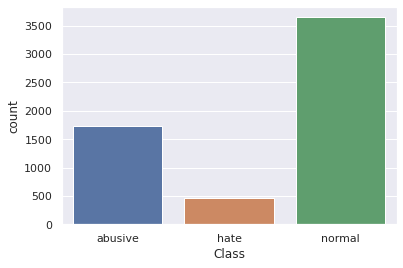

In [92]:
ax=sns.countplot(x='Class', data=origin_ds)


In [93]:
#origin_ds["Class"] = origin_ds["Class"].cat.rename_categories({"abusive": "hatee"})
origin_ds['Class'].replace('abusive','hate',inplace=True)


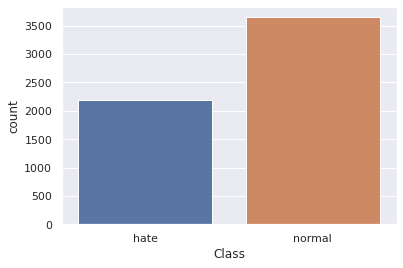

In [94]:
ax=sns.countplot(x='Class', data=origin_ds)


In [95]:
#incode the catagorical values into inger
origin_ds["Class"].replace({"normal":"0","hate":"1"},inplace=True)

#

In [96]:
#split the data into training and testing valeus 80 20 
origin_ds['Class'].value_counts()
test_data = origin_ds.sample(frac=0.2,random_state=200)
test_data.shape
data=origin_ds.drop(test_data.index)
data.shape,test_data.shape

((4677, 2), (1169, 2))

In [97]:
#rename the data column for easy exctraction 
data.rename(columns={'Tweet':'texts'}, inplace=True)
test_data.rename(columns={'Tweet':'texts'}, inplace=True)
data.rename(columns={'Class':'data_labels'}, inplace=True)
test_data.rename(columns={'Class':'data_labels'}, inplace=True)

implement Data agumentation

In [98]:

import random

random.seed(0)

PUNCTUATIONS = ['.', ',', '!', '?', ';', ':']
NUM_AUGS = [1, 2,]
PUNC_RATIO = 0.4

# Insert punction words into a given sentence with the given ratio "punc_ratio"
def insert_punctuation_marks(sentence, punc_ratio=PUNC_RATIO):
	words = sentence.split(' ')
	new_line = []
	q = random.randint(1, int(punc_ratio * len(words) + 1))
	qs = random.sample(range(0, len(words)), q)

	for j, word in enumerate(words):
		if j in qs:
			new_line.append(PUNCTUATIONS[random.randint(0, len(PUNCTUATIONS)-1)])
			new_line.append(word)
		else:
			new_line.append(word)
	new_line = ' '.join(new_line)
	return new_line

    


In [99]:

import os
import sys
from google.colab import drive
drive.mount('/content/drive/')
copy_dataset=data.copy(deep=True)



data_file_name='out.csv'
list_of_files=os.listdir('/content/drive/MyDrive/Colab Notebooks/NLP_SA')
if data_file_name in list_of_files:
  copy_dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP_SA/out.csv',encoding='utf-8-sig')

else:

  copy_dataset=data.copy(deep=True)
  copy_dataset.reset_index(drop=True,inplace=True)
  data_aug = []
  for aug in tq.tqdm(NUM_AUGS):
    for index, row in tq.tqdm(copy_dataset.iterrows()):
      for i in range(aug):
        sentence_aug = insert_punctuation_marks(row['texts'])
        copy_dataset.loc[len(copy_dataset)] = [sentence_aug, row['data_labels']]
  copy_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP_SA/out.csv', index=False,encoding='utf-8-sig')  

        #print(row['texts'], row['data_labels'])


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [100]:
#saving the data into training and testing
#from sklearn.model_selection import train_test_split

#X_train = data.texts.values
#Y_train = data.data_labels.values

X_train = copy_dataset.texts.values
Y_train = copy_dataset.data_labels.values

X_val= test_data.texts.values
Y_val = test_data.data_labels.values

#modeling


In [101]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [102]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [103]:
import os
import re
import nltk
import numpy as np
import pandas as pd
from nltk import tokenize
nltk.download('stopwords')
!pip install emoji
import spacy
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import string
from sklearn.utils import shuffle

#from emoji import UNICODE_EMOJI
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
#remove arabic stopwords
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

#remove 3lamat al tashkeel
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

#remove arabic and english punctuation

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [105]:
def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text

def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text
#Text Normalization
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in arb_stopwords]
    return ' '.join(filtered_sentence)


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)

In [106]:
def clean_content(line):
    if (isinstance(line, float)):
        return None
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    nline = [w if '@' not in w else 'USERIDX' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '')


    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations_list}))

    # then remove punc,
    
    #translator = str.maketrans('', '', punctuations_list)
    #line = line.translate(translator)

    line=remove_diacritics(normalize_arabic(line))

    line = remove_stopwords(line)

    #replace number
    nline = [word if not hasDigits(word) else '<NUM>' for word in line.split()]
    line = ' '.join(nline)

    return line

In [107]:
# Print sentence 0
print('Original: ', X_train[1500])
print('Processed: ', text_preprocessing(X_train[1500]))


Original:  لقد تم سحقهم أيها العزيز❤ 
Processed:  لقد تم سحقهم أيها العزيز❤


## bert arabic toknizer

In [108]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02', do_lower_case=True)

In [109]:

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=clean_content(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [110]:
max_len = 512
# Concatenate train data and test data

#all_tweets = np.concatenate([data.texts.values, test_data.texts.values])
all_tweets = np.concatenate([copy_dataset.texts.values, test_data.texts.values])


In [111]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

In [112]:
# Find the maximum length
max_len1 = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len1)

Max length:  169


In [113]:
# Specify `MAX_LEN`
MAX_LEN = 256

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه سنيه شيعية واعادة توزيع ديموغرافي بسوريا
Token IDs:  [2, 24045, 740, 2298, 10424, 195, 5541, 195, 4533, 4745, 5541, 195, 28168, 195, 36414, 195, 2659, 1867, 3668, 4524, 40479, 24614, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [114]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(Y_train.astype(float))
val_labels = torch.tensor(Y_val.astype(float))

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [115]:
def save_checkpoint(state,file_name='/content/drive/MyDrive/Colab Notebooks/NLP_SA/training_checkpoint.pth.tar'):
  print('************************** saving checkpoint **************************')
  torch.save(state,file_name)

In [116]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels

        # why 768
        #D_in, H, D_out = 768, 50, 2
        
        D_in, H1,H2,H3, D_out = 768, 512,256,64, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('aubmindlab/bert-base-arabertv02')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            #nn.Linear(D_in, H),
            #nn.ReLU(),
            nn.Linear(D_in, H1),
            nn.ReLU(),
            
            nn.Linear(H1, H2),
            nn.ReLU(),

            nn.Linear(H2, H3),
            nn.ReLU(),
            
            nn.Dropout(0.5),
            #nn.Linear(H, D_out)
            nn.Linear(H3,D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 0 ns, sys: 60 µs, total: 60 µs
Wall time: 65.1 µs


In [117]:

from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    #optimizer = AdamW(bert_classifier.parameters(),
                      #lr=5e-5,    # Default learning rate
                      #eps=1e-8    # Default epsilon value
                      #)
    optimizer = torch.optim.AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [118]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RN
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels.long())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
          
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
              checkpoint= {'state_dict':model.state_dict(), 'optimizer':optimizer.state_dict()}
              save_checkpoint(checkpoint)
 




        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
        #torch.save(model.state_dict(), './mymodel.h5')
        #model.save_pretrained('./mymodel.h5',model)
        torch.save(model, './mymodel1.h5')
        
    torch.save(model, './mymodel1.h5')
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels.long())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [119]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [120]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.653300   |     -      |     -     |   27.44  
   1    |   40    |   0.566830   |     -      |     -     |   27.27  
   1    |   60    |   0.477189   |     -      |     -     |   27.23  
   1    |   80    |   0.432680   |     -      |     -     |   26.97  
   1    |   100   |   0.399484   |     -      |     -     |   27.13  
************************** saving checkpoint **************************
   1    |   120   |   0.388651   |     -      |     -     |   33.66  
   1    |   140   |   0.366325   |     -      |     -     |   27.26  
   1    |   160   |   0.340955   |     -      |     -     |   27.00  
   1    |   180   |   0.332994   |     -      |     -     |   27.14  
   1    |   200   |   0.295778   |     -      |     -     |   27.17  
************************** saving checkpoint ***********************

In [121]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [122]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9247
Accuracy: 88.54%


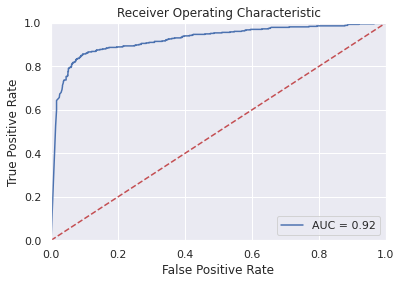

In [123]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, Y_val.astype(float))

In [124]:
preds=probs[:,1]
y_pred = np.where(preds >= 0.5, 1, 0)


In [125]:
confusion_matrix = pd.crosstab( Y_val.astype(float),y_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0    1
Actual             
0.0        663   72
1.0         62  372


In [126]:
import os
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics

In [127]:
sklearn.metrics.confusion_matrix(Y_val.astype(float), y_pred,  labels=None, sample_weight=None, normalize=None)

array([[663,  72],
       [ 62, 372]])

In [128]:
array = pd.crosstab(Y_val.astype(float), y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [129]:
array

Predicted,0,1,All
Actual,,,
0.0,663,72,735
1.0,62,372,434
All,725,444,1169


In [130]:
print(classification_report(Y_val.astype(float), y_pred))


              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91       735
         1.0       0.84      0.86      0.85       434

    accuracy                           0.89      1169
   macro avg       0.88      0.88      0.88      1169
weighted avg       0.89      0.89      0.89      1169



In [131]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

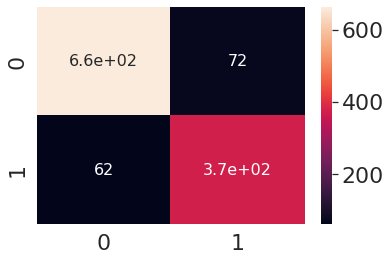

In [132]:
df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size